## POS tagging using modified Viterbi

### Data Preparation

In [1]:
# Importing libraries

import nltk
import random
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pprint,time
from nltk.tokenize import word_tokenize

In [2]:
# Reading the Treebank tagged sentences

nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [3]:
# Let us check the first few tagged sentences

print(nltk_data[:30])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

In [4]:
# Splitting into data into train and test sets in the ratio 95:5

random.seed(1234)
train_set, test_set = train_test_split(nltk_data,train_size=0.95, test_size=0.05, random_state = 3)

print("Train Data Set Length : ", len(train_set))
print("Test Data Set Length : ", len(test_set))

print("Train Data Set -\n")
print(train_set[:30])

Train Data Set Length :  3718
Test Data Set Length :  196
Train Data Set -

[[('The', 'DET'), ('vacation', 'NOUN'), ('packages', 'NOUN'), ('include', 'VERB'), ('hotel', 'NOUN'), ('accommodations', 'NOUN'), ('and', 'CONJ'), (',', '.'), ('in', 'ADP'), ('some', 'DET'), ('cases', 'NOUN'), (',', '.'), ('tours', 'NOUN'), ('or', 'CONJ'), ('tickets', 'NOUN'), ('to', 'PRT'), ('local', 'ADJ'), ('attractions', 'NOUN'), (',', '.'), ('but', 'CONJ'), ('not', 'ADV'), ('meals', 'NOUN'), ('.', '.')], [('For', 'ADP'), ('the', 'DET'), ('first', 'ADJ'), ('time', 'NOUN'), (',', '.'), ('the', 'DET'), ('October', 'NOUN'), ('survey', 'NOUN'), ('polled', 'VERB'), ('members', 'NOUN'), ('on', 'ADP'), ('imports', 'NOUN'), ('.', '.')], [('She', 'PRON'), ('says', 'VERB'), ('that', 'ADP'), ('because', 'ADP'), ('of', 'ADP'), ('Mrs.', 'NOUN'), ('Yeargin', 'NOUN'), ('she', 'PRON'), ('gave', 'VERB'), ('up', 'PRT'), ('ambitions', 'NOUN'), ('in', 'ADP'), ('architecture', 'NOUN'), ('and', 'CONJ'), ('is', 'VERB'), ('studyin

In [5]:
# Getting the list of tagged words from both train and test data sets

train_tagged_words = [tup for sent in train_set for tup in sent]
print("Train Tagged Words : ", len(train_tagged_words))

test_tagged_words = [tup[0] for sent in test_set for tup in sent]
print("Test Tagged Words : ", len(test_tagged_words))

Train Tagged Words :  95680
Test Tagged Words :  4996


In [6]:
# Let us look at few of the the tagged words in the training data set

train_tagged_words[:30]

[('The', 'DET'),
 ('vacation', 'NOUN'),
 ('packages', 'NOUN'),
 ('include', 'VERB'),
 ('hotel', 'NOUN'),
 ('accommodations', 'NOUN'),
 ('and', 'CONJ'),
 (',', '.'),
 ('in', 'ADP'),
 ('some', 'DET'),
 ('cases', 'NOUN'),
 (',', '.'),
 ('tours', 'NOUN'),
 ('or', 'CONJ'),
 ('tickets', 'NOUN'),
 ('to', 'PRT'),
 ('local', 'ADJ'),
 ('attractions', 'NOUN'),
 (',', '.'),
 ('but', 'CONJ'),
 ('not', 'ADV'),
 ('meals', 'NOUN'),
 ('.', '.'),
 ('For', 'ADP'),
 ('the', 'DET'),
 ('first', 'ADJ'),
 ('time', 'NOUN'),
 (',', '.'),
 ('the', 'DET'),
 ('October', 'NOUN')]

In [7]:
# Let us view the tokens of the training data set

train_tagged_tokens = [tag[0] for tag in train_tagged_words]
train_tagged_tokens[:30]

['The',
 'vacation',
 'packages',
 'include',
 'hotel',
 'accommodations',
 'and',
 ',',
 'in',
 'some',
 'cases',
 ',',
 'tours',
 'or',
 'tickets',
 'to',
 'local',
 'attractions',
 ',',
 'but',
 'not',
 'meals',
 '.',
 'For',
 'the',
 'first',
 'time',
 ',',
 'the',
 'October']

In [8]:
# Let us see the POS tags for the tokens of the training data set

train_tagged_pos_tokens = [tag[1] for tag in train_tagged_words]
train_tagged_pos_tokens[:30]

['DET',
 'NOUN',
 'NOUN',
 'VERB',
 'NOUN',
 'NOUN',
 'CONJ',
 '.',
 'ADP',
 'DET',
 'NOUN',
 '.',
 'NOUN',
 'CONJ',
 'NOUN',
 'PRT',
 'ADJ',
 'NOUN',
 '.',
 'CONJ',
 'ADV',
 'NOUN',
 '.',
 'ADP',
 'DET',
 'ADJ',
 'NOUN',
 '.',
 'DET',
 'NOUN']

In [9]:
# Let us build the train vocabulary set

V = set(train_tagged_tokens)

In [10]:
# Let us now build the train POS tag set

train_pos_tag_set = set(train_tagged_pos_tokens)

In [11]:
# let us check the unique number of tags in the train data set

print(len(train_pos_tag_set))

12


In [12]:
# let us now check the number of words in the train vocabulary set

print(len(V))

12095


### Build the Vanilla Viterbi based POS tagger

In [13]:
# Computing P(w/t) and storing in t x v matrix

t = len(train_pos_tag_set)
v = len(V)
w_given_t = np.zeros((t, v))

In [14]:
# Function to compute the Emission Probability (word given tag)

def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [15]:
# Function to compute the Transition Probability [tag given tag : tag2(t2) given tag1 (t1)]

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [16]:
# Creating t x t transition matrix of tags
# Each column is t2, each row is t1
# Thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(train_pos_tag_set), len(train_pos_tag_set)), dtype='float32')
for i, t1 in enumerate(list(train_pos_tag_set)):
    for j, t2 in enumerate(list(train_pos_tag_set)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [17]:
tags_matrix

array([[7.68049154e-03, 5.37634408e-03, 7.68049154e-03, 9.98463947e-03,
        2.06221193e-01, 9.29339454e-02, 1.22887865e-02, 4.85791087e-01,
        4.22427021e-02, 3.45622115e-02, 2.26574503e-02, 7.25806430e-02],
       [5.86319230e-02, 4.65332705e-04, 4.00186144e-02, 1.19125172e-01,
        3.53187531e-01, 8.37598927e-03, 5.11865970e-03, 1.56351790e-01,
        3.58306207e-02, 5.67705892e-02, 5.07212654e-02, 1.15402512e-01],
       [1.48367952e-03, 1.42433234e-02, 1.83679521e-01, 2.96735903e-03,
        3.49258155e-01, 2.10089028e-01, 2.81899106e-02, 1.83976255e-02,
        1.20178044e-01, 3.26409494e-03, 3.44213657e-02, 3.38278934e-02],
       [3.62362596e-03, 4.83150128e-04, 2.25872695e-02, 5.43543929e-03,
        6.36429548e-01, 4.52953242e-02, 2.41575064e-04, 3.99806723e-02,
        1.75141934e-02, 1.30450539e-02, 8.93827714e-03, 2.06425890e-01],
       [4.74210270e-03, 4.27518785e-02, 9.33829416e-03, 1.29131097e-02,
        2.64244556e-01, 2.91821696e-02, 4.42474633e-02, 1.47

In [18]:
# Convert the matrix to a dataframe for better readability purpose

tags_df = pd.DataFrame(tags_matrix, columns = list(train_pos_tag_set), index=list(train_pos_tag_set))
tags_df

,PRON,CONJ,NUM,DET,NOUN,X,PRT,VERB,.,ADV,ADP,ADJ
PRON,0.007680,0.005376,0.007680,0.009985,0.206221,0.092934,0.012289,0.485791,0.042243,0.034562,0.022657,0.072581
CONJ,0.058632,0.000465,0.040019,0.119125,0.353188,0.008376,0.005119,0.156352,0.035831,0.056771,0.050721,0.115403
NUM,0.001484,0.014243,0.183680,0.002967,0.349258,0.210089,0.028190,0.018398,0.120178,0.003264,0.034421,0.033828
DET,0.003624,0.000483,0.022587,0.005435,0.636430,0.045295,0.000242,0.039981,0.017514,0.013045,0.008938,0.206426
NOUN,0.004742,0.042752,0.009338,0.012913,0.264245,0.029182,0.044247,0.147115,0.239695,0.017145,0.176224,0.012402
X,0.055308,0.010648,0.002543,0.054514,0.062142,0.075016,0.184202,0.205499,0.163382,0.025270,0.143992,0.017483
PRT,0.018893,0.002280,0.057329,0.100977,0.246580,0.014007,0.001629,0.398697,0.043322,0.010423,0.021173,0.084691
VERB,0.035620,0.005343,0.023385,0.135589,0.109803,0.217361,0.031516,0.169351,0.035156,0.080842,0.091529,0.064504
.,0.066009,0.057399,0.080448,0.172466,0.223318,0.027623,0.002422,0.089148,0.094529,0.051300,0.091121,0.044126
ADV,0.014980,0.006991,0.032623,0.068242,0.032290,0.023302,0.013981,0.345539,0.134487,0.080226,0.117177,0.130160


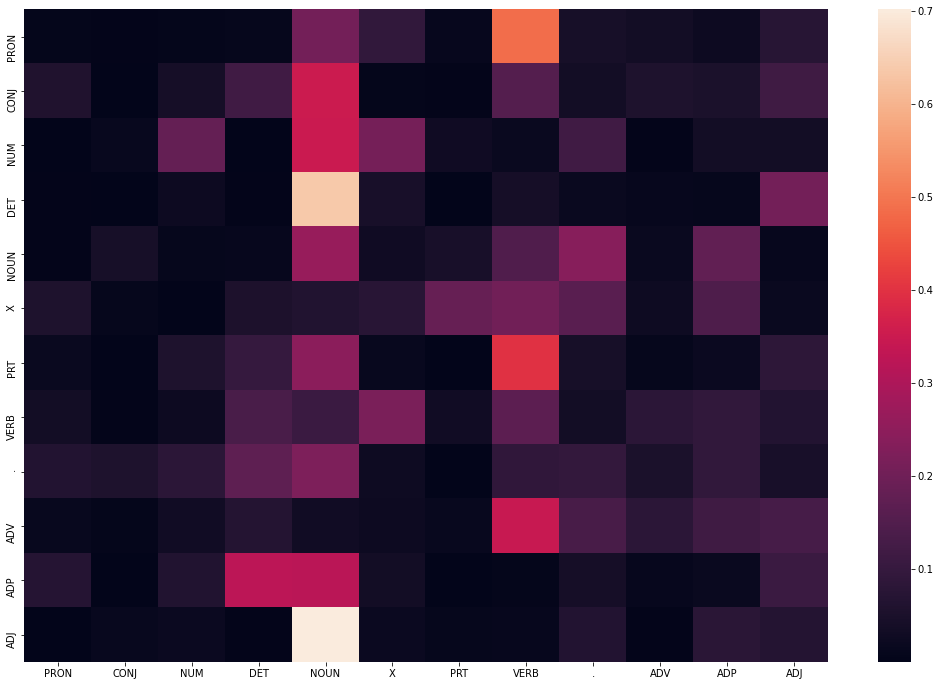

In [19]:
# Heatmap of tags matrix
# T(i, j) means P(tag j given tag i)

plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()

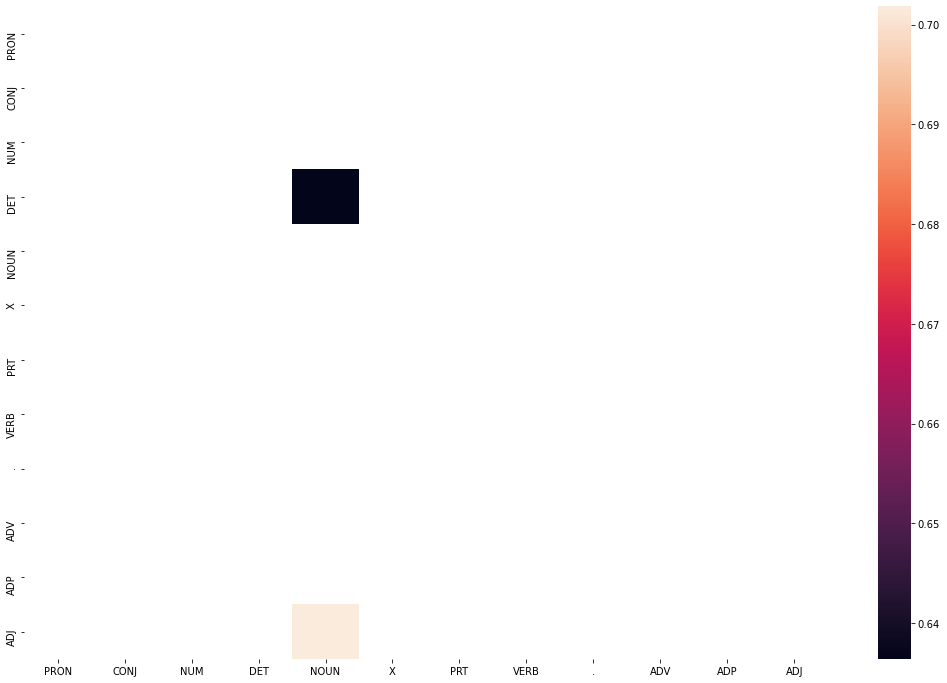

In [20]:
# Frequent tags
# Filter the df to get P(t2, t1) > 0.5

tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

In [21]:
# Viterbi Heuristic
 
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        # Initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # Compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # Getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [22]:
# Let us test Viterbi algorithm on a few sample sentences of test dataset

random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]

In [23]:
# Tagging the test sentences

start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start
print("Time taken in seconds: ", difference)

Time taken in seconds:  41.00134515762329


In [24]:
# Printing the tagged words from the test data set

print(tagged_seq)

[('Chrysler', 'NOUN'), ('said', 'VERB'), ('0', 'X'), ('its', 'PRON'), ('trucks', 'NOUN'), ('and', 'CONJ'), ('vans', 'NOUN'), ('already', 'ADV'), ('meet', 'VERB'), ('the', 'DET'), ('roof-crush', 'ADJ'), ('resistance', 'NOUN'), ('standard', 'ADJ'), ('for', 'ADP'), ('cars', 'NOUN'), ('.', '.'), ('*-2', 'X'), ('Developed', 'PRON'), ('*-1', 'X'), ('by', 'ADP'), ('Avrett', 'PRON'), (',', '.'), ('Free', 'NOUN'), ('&', 'CONJ'), ('Ginsberg', 'PRON'), (',', '.'), ('New', 'NOUN'), ('York', 'NOUN'), (',', '.'), ('the', 'DET'), ('$', '.'), ('6', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('campaign', 'NOUN'), ('pitches', 'PRON'), ('Enterprise', 'NOUN'), ("'s", 'PRT'), ('consumer-driven', 'PRON'), ('service', 'NOUN'), ('and', 'CONJ'), ('its', 'PRON'), ('free', 'ADJ'), ('pick-up', 'PRON'), ('and', 'CONJ'), ('drop-off', 'PRON'), ('service', 'NOUN'), ('.', '.'), ('January', 'NOUN'), ('platinum', 'PRON'), ('was', 'VERB'), ('down', 'ADV'), ('$', '.'), ('5.70', 'PRON'), ('*U*', 'X'), ('an', 'DET'), ('ounce

In [25]:
# Accuracy

vanilla_viterbi_check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
vanilla_viterbi_accuracy = len(vanilla_viterbi_check)/len(tagged_seq) * 100
print('Vanilla Viterbi Algorithm Accuracy : ', vanilla_viterbi_accuracy)

Vanilla Viterbi Algorithm Accuracy :  81.66666666666667


In [26]:
# let us now check the incorrectly tagged words

incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]

print("Total Incorrect Tagged Words : ", len(incorrect_tagged_cases))
print("\n")
print("Incorrect Tagged Words : ", incorrect_tagged_cases)

Total Incorrect Tagged Words :  22


Incorrect Tagged Words :  [[('resistance', 'NOUN'), (('standard', 'ADJ'), ('standard', 'NOUN'))], [('*-2', 'X'), (('Developed', 'PRON'), ('Developed', 'VERB'))], [('by', 'ADP'), (('Avrett', 'PRON'), ('Avrett', 'NOUN'))], [('&', 'CONJ'), (('Ginsberg', 'PRON'), ('Ginsberg', 'NOUN'))], [('campaign', 'NOUN'), (('pitches', 'PRON'), ('pitches', 'VERB'))], [("'s", 'PRT'), (('consumer-driven', 'PRON'), ('consumer-driven', 'ADJ'))], [('free', 'ADJ'), (('pick-up', 'PRON'), ('pick-up', 'ADJ'))], [('and', 'CONJ'), (('drop-off', 'PRON'), ('drop-off', 'ADJ'))], [('January', 'NOUN'), (('platinum', 'PRON'), ('platinum', 'NOUN'))], [('was', 'VERB'), (('down', 'ADV'), ('down', 'ADP'))], [('$', '.'), (('5.70', 'PRON'), ('5.70', 'NUM'))], [('$', '.'), (('494.50', 'PRON'), ('494.50', 'NUM'))], [('Structural', 'NOUN'), (('Dynamics', 'PRON'), ('Dynamics', 'NOUN'))], [('which', 'DET'), (('*T*-143', 'PRON'), ('*T*-143', 'X'))], [('makes', 'VERB'), (('computer-aided', 'PRON'

Unknows words are those words that are present in the test set but not in the train set, i.e., the words the algorithm has not seen before. Let us now look into such unknown words

In [27]:
# Unknown words 

test_vocabulary_set = set([t for t in test_tagged_words])

unknown_words = list(test_vocabulary_set - V)       # V is the train vocabulary set as obtained before in cell# 9

print("Total Unknown words : ", len(unknown_words))
print("\n")
print("Unknown Words : ", unknown_words)

Total Unknown words :  18


Unknown Words :  ['Dynamics', 'chronicle', '*T*-143', 'computer-aided', 'drop-off', 'platinum', 'consumer-driven', 'pitches', 'automation', 'productivity', 'Avrett', '494.50', '5.70', 'rationed', 'pick-up', '*T*-144', 'Ginsberg', 'Developed']


### Solve the problem of unknown words

#### Lexicon/Unigram Tagger

Let us first try training a lexicon/unigram tagger which assigns the most commonly assigned tag to a word

In [28]:
unigram_tagger = nltk.UnigramTagger(train_set)
unigram_tagger.evaluate(test_set)

0.9083266613290633

#### Rule-Based (Regular Expression) Tagger

Let us now try the rule based regex approach

In [29]:
patterns = [
    (r'^[aA-zZ].*[0-9]+','NOUN'),  # Alpha Numeric
    (r'.*ness$', 'NOUN'),
    (r'.*\'s$', 'NOUN'),              # possessive nouns
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'.*', 'NOUN'),    
    (r'.*ly$', 'ADV'),
    (r'^(0|([*|-|$].*))','X'), # Any special character combination
    (r'.*ould$', 'X'), # modals
    (r'(The|the|A|a|An|an)$', 'DET'),
    (r'^([0-9]|[aA-zZ])+\-[aA-zZ]*$','ADJ'),
    (r'.*able$', 'ADJ'), # adjective like 100-megabytes 237-Seats
    (r'[aA-zZ]+(ed|ing|es)$', 'VERB'), # Any word ending with 'ing' or 'ed' is a verb
    (r'[0-9].?[,\/]?[0-9]*','NUM')# Numbers 
    ]

In [30]:
regexp_tagger = nltk.RegexpTagger(patterns)
accuracy_regexp_tagger = regexp_tagger.evaluate(test_set)
print("The accuracy of the Regex Rule-Based Tagger is : ", accuracy_regexp_tagger)

The accuracy of the Regex Rule-Based Tagger is :  0.2908326661329063


#### Unigram Tagger backed by Regex Rule-Based Unigram Tagger

Let us now try combining the unigram tagger with the rule based regex tagger, as defined above

In [31]:
# Unigram tagger backed by the rule-based tagger

rule_based_unigram_tagger = nltk.UnigramTagger(train_set, backoff = regexp_tagger)

accuracy_rule_based_unigram_tagger = rule_based_unigram_tagger.evaluate(test_set)

print("The accuracy of the Unigram Tagger backed by the Regex Rule-Based Tagger is : ", accuracy_rule_based_unigram_tagger)

The accuracy of the Unigram Tagger backed by the Regex Rule-Based Tagger is :  0.9419535628502802


#### Bigram Tagger backed by Regex Rule-Based Unigram Tagger

Let us now try combining the bigram tagger with the regex rule based unigram tagger, as defined above

In [32]:
# Bigram tagger backed by the regex rule-based unigram tagger

bigram_tagger = nltk.BigramTagger(train_set, backoff=rule_based_unigram_tagger)
accuracy_bigram_tagger = bigram_tagger.evaluate(test_set)
print("The accuracy of the Bigram Tagger backed by the Regex Rule-Based Unigram Tagger is : ", accuracy_bigram_tagger)

The accuracy of the Bigram Tagger backed by the Regex Rule-Based Unigram Tagger is :  0.9473578863090473


#### Trigram Tagger backed by Bigram Tagger

Let us now try combining the trigram tagger with the bigram tagger, as defined above

In [33]:
# Trigram tagger backed by the bigram tagger

trigram_tagger = nltk.TrigramTagger(train_set, backoff = bigram_tagger)
accuracy_trigram_tagger = trigram_tagger.evaluate(test_set)
print("The accuracy of the Trigram Tagger backed by the bigram_tagger is -", accuracy_trigram_tagger)

The accuracy of the Trigram Tagger backed by the bigram_tagger is - 0.9473578863090473


#### Viterbi Modification - Technique I

For unknown words, the emission probability i.e., pmax value, as declared and defined in the original Viterbi Heuristic, is 0. In such cases, let us use the transition probability and check the accuracy of the same.

In [34]:
# Use transition probability of tags when emission probability is zero (for unknown words)

def Vanilla_Viterbi_Technique_1(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #Initialise list of probability column for a given observation
        p = [] 
        p_transition =[] # list for storing transition probabilities
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # Compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            p_transition.append(transition_p)
            
        pmax = max(p)
        state_max = T[p.index(pmax)] 
        
      
        # If emission probability is zero (unknown word) then use transition probability
        
        if(pmax==0):
            pmax = max(p_transition)
            state_max = T[p_transition.index(pmax)]
                           
        else:
            state_max = T[p.index(pmax)] 
        
        state.append(state_max)
    return list(zip(words, state))

In [35]:
# Tagging the test sentences and checking the accuracy

start = time.time()
tagged_seq = Vanilla_Viterbi_Technique_1(test_tagged_words)
end = time.time()
difference = end-start
print("Time taken in seconds: ", difference)

viterbi_1_check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
viterbi_1_accuracy = len(viterbi_1_check)/len(tagged_seq) * 100
print('Viterbi Technique 1 Accuracy : ', viterbi_1_accuracy)

Time taken in seconds:  41.1293523311615
Viterbi Technique 1 Accuracy :  86.66666666666667


**Accuracy of the modified Viterbi Algorithm (transition probability is used for unknown words) = 86.66%**

So, to some extent, the modified version is better.

Let us further try to improve this modified version, by assigning Tag Occurence Probability Weights.

In [36]:
# let us create a list of tuples for POS tags and POS tag occurance probability, upon the train data set

tag_prob = []
total_tag = len([tag for word,tag in train_tagged_words])
for t in train_pos_tag_set:  # T is the train POS tag set, as defined in cel#10
    each_tag = [tag for word,tag in train_tagged_words if tag==t]
    tag_prob.append((t,len(each_tag)/total_tag))

tag_prob

[('PRON', 0.02721571906354515),
 ('CONJ', 0.022460284280936455),
 ('NUM', 0.03522157190635451),
 ('DET', 0.08652801003344482),
 ('NOUN', 0.2865175585284281),
 ('X', 0.06576086956521739),
 ('PRT', 0.03208612040133779),
 ('VERB', 0.13497073578595317),
 ('.', 0.11653428093645485),
 ('ADV', 0.031396321070234115),
 ('ADP', 0.09765886287625418),
 ('ADJ', 0.06364966555183947)]

In [37]:
# Let us now modify the Vanilla_Viterbi_Technique_1 algorith (as defined in cell# 34)

def Vanilla_Viterbi_Technique_1_Modified(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        # Initialise list of probability column for a given observation
        p = [] 
        p_transition =[] # list for storing transition probabilities
       
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # Compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
            # Find POS tag occurance probability
            tag_p = [pair[1] for pair in tag_prob if pair[0]==tag ]
            
            # Calculate the transition prob weighted by tag occurance probability
            transition_p = tag_p[0]*transition_p             
            p_transition.append(transition_p)
            
        pmax = max(p)
        state_max = T[p.index(pmax)] 
        
      
        # If emission probability is zero (for unknown word) then use weighted transition probability
        
        if(pmax==0):
            pmax = max(p_transition)
            state_max = T[p_transition.index(pmax)]                 
                           
        else:
            state_max = T[p.index(pmax)] 
        
        state.append(state_max)
    return list(zip(words, state))

In [38]:
# Tagging the test sentences and checking the accuracy

start = time.time()
tagged_seq = Vanilla_Viterbi_Technique_1_Modified(test_tagged_words)
end = time.time()
difference = end-start
print("Time taken in seconds: ", difference)

viterbi_1_mod_check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
viterbi_1_mod_accuracy = len(viterbi_1_mod_check)/len(tagged_seq) * 100
print('Viterbi Technique 1 (Modified) Accuracy : ', viterbi_1_mod_accuracy)

Time taken in seconds:  41.14435338973999
Viterbi Technique 1 (Modified) Accuracy :  88.33333333333333


**Accuracy of the modified Viterbi Algorithm (transition probability is used for unknown words) = 86.66%**

**Accuracy of the modified Viterbi Algorithm (weighted transition probability is used for unknown words) = 88.33%**

Well, the updated version of Viterbi Technique 1, thereby using the weighted tranistion probability for unknown words, seems to working well, with over 88% accuracy.

#### Viterbi Modification - Technique II

Let us now, try to modify the original Viterbi Algorithm, by using the regex rule-based trigram tagger

In [39]:
def trigram_tagger(word, train_set = train_set):
    
    patterns = [
    (r'[aA-zZ]+(ed|ing|es)$', 'VERB'), # Any word ending with 'ing' or 'ed' is a verb

    (r'.*ly$', 'ADV'),
        
    (r'^([0-9]|[aA-zZ])+\-[aA-zZ]*$','ADJ'),
    (r'.*able$', 'ADJ'), 
    (r'.*ful$', 'ADJ'),
    (r'.*ous$', 'ADJ'),
        
    (r'^[aA-zZ].*[0-9]+','NOUN'),     # Alpha Numeric
    (r'.*ness$', 'NOUN'),
    (r'.*\'s$', 'NOUN'),              # possessive nouns - words ending with 's
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'.*ers$', 'NOUN'),              # eg.- kinderganteners, autobioghapgers
    (r'.*ment$', 'NOUN'),
    (r'.*town$', 'NOUN'),
        
    (r'^(0|([*|-|$].*))','X'), # Any special character combination
    (r'.*ould$', 'X'),
        
    (r'(The|the|A|a|An|an|That|that|This|this|Those|those|These|these)$', 'DET'), # That/this/these/those belong to the category of Demonstrative determiners
    (r'[0-9].?[,\/]?[0-9]*','NUM'), # Numbers 
        
    (r'.*', 'NOUN')
    ]
    
    regex_based_tagger = nltk.RegexpTagger(patterns)

    # trigram tagger backed by the regex tagger
    
    trigram_regex_tagger = nltk.TrigramTagger(train_set, backoff = regex_based_tagger)
    return trigram_regex_tagger.tag_sents([[(word)]])

In [40]:
# Use regex rule-based trigram tagger for unknown words

def Vanilla_Viterbi_Technique_2(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        
        # Modification for unknown words where regex rule based trigram tagger is to be used
        
        if word not in V:    # V is the train vocabulary set, as defined in cell#9
            unk_word_tag=trigram_tagger(word)
            for sent in unk_word_tag:
                for tup in sent:
                    state.append(tup[1])
        # rest remains same            
        else:            
            p = [] 
            for tag in T:
                if key == 0:
                    transition_p = tags_df.loc['.', tag]
                else:
                    transition_p = tags_df.loc[state[-1], tag]
                
            # Compute emission and state probabilities
            
                emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
                state_probability = emission_p * transition_p    
                p.append(state_probability)
            
            pmax = max(p)
            # Getting state for which probability is maximum
            
            state_max = T[p.index(pmax)] 
            state.append(state_max)
            
    return list(zip(words, state))

In [41]:
# Tagging the test sentences and checking the accuracy

start = time.time()
tagged_seq = Vanilla_Viterbi_Technique_2(test_tagged_words)
end = time.time()
difference = end-start
print("Time taken in seconds: ", difference)

viterbi_2_check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
viterbi_2_accuracy = len(viterbi_2_check)/len(tagged_seq) * 100
print('Viterbi Technique 2 Accuracy : ', viterbi_2_accuracy)

Time taken in seconds:  143.5792121887207
Viterbi Technique 2 Accuracy :  96.66666666666667


**Accuracy of the modified Viterbi Algorithm (transition probability is used for unknown words) = 86.66%**

**Accuracy of the modified Viterbi Algorithm (weighted transition probability is used for unknown words) = 88.33%**

**Accuracy of the modified Viterbi Algorithm (Regex Rule-Based Trigram Tagger is used for unknown words) = 96.66%**

With Regex Rule-Based Trigram Tagger, the modified Viterbi Algorithm has accuracy of almost 97%.

### Compare the tagging accuracies of the modifications with the Vanilla Viterbi algorithm

In [42]:
acccuracy_data = [['Vanilla Viterbi Algorithm', vanilla_viterbi_accuracy], 
                  ['Vanilla Viterbi Algorithm Modified - I (Weighted Transition Probability used for unknown words)', viterbi_1_mod_accuracy],
                  ['Vanilla Viterbi Algorithm Modified - II (Regex Rule-Based Trigram Tagger used for unknown words)', viterbi_2_accuracy]]

acccuracy_data_df = pd.DataFrame(acccuracy_data, columns = ['Tagging Algorithm', 'Algorithm Accuracy'])

acccuracy_data_df.set_index('Tagging Algorithm', drop = True, inplace = True)

acccuracy_data_df

,Algorithm Accuracy
Tagging Algorithm,
Vanilla Viterbi Algorithm,81.666667
Vanilla Viterbi Algorithm Modified - I (Weighted Transition Probability used for unknown words),88.333333
Vanilla Viterbi Algorithm Modified - II (Regex Rule-Based Trigram Tagger used for unknown words),96.666667


### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

Now we will test 5 sentences from the sample test file, as provided.

In [43]:
sentence_test_1 = 'Android is a mobile operating system developed by Google.'

words_1 = word_tokenize(sentence_test_1)

In [44]:
# Let us first try with Vanilla Viterbi Algorithm

tagged_seq_1_a = Viterbi(words_1)
print(tagged_seq_1_a)

[('Android', 'PRON'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'PRON'), ('.', '.')]


In [45]:
# Now let us check with Vanilla Viterbi Algorithm Modified - I (Weighted Transition Probability used for unknown words)

tagged_seq_1_b = Vanilla_Viterbi_Technique_1_Modified(words_1)
print(tagged_seq_1_b)

[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.')]


In [46]:
# Now let us check with Vanilla Viterbi Algorithm Modified - II (Regex Rule-Based Trigram Tagger used for unknown words)

tagged_seq_1_c = Vanilla_Viterbi_Technique_2(words_1)
print(tagged_seq_1_c)

[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.')]


In [47]:
sentence_test_2 = "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose."

words_2 = word_tokenize(sentence_test_2)

In [48]:
# Let us first try with Vanilla Viterbi Algorithm

tagged_seq_2_a = Viterbi(words_2)
print(tagged_seq_2_a)

[('Google', 'PRON'), ('and', 'CONJ'), ('Twitter', 'PRON'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'PRON'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'PRON'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'PRON'), ("'s", 'VERB'), ('firehose', 'PRON'), ('.', '.')]


In [49]:
# Now let us check with Vanilla Viterbi Algorithm Modified - I (Weighted Transition Probability used for unknown words)

tagged_seq_2_b = Vanilla_Viterbi_Technique_1_Modified(words_2)
print(tagged_seq_2_b)

[('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NOUN'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'NOUN'), ("'s", 'PRT'), ('firehose', 'NOUN'), ('.', '.')]


In [50]:
# Now let us check with Vanilla Viterbi Algorithm Modified - II (Regex Rule-Based Trigram Tagger used for unknown words)

tagged_seq_2_c = Vanilla_Viterbi_Technique_2(words_2)
print(tagged_seq_2_c)

[('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NUM'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'NOUN'), ("'s", 'PRT'), ('firehose', 'NOUN'), ('.', '.')]


In [51]:
sentence_test_3 = 'NASA invited social media users to experience the launch of ICESAT-2 Satellite'

words_3 = word_tokenize(sentence_test_3)

In [52]:
# Let us first try with Vanilla Viterbi Algorithm

tagged_seq_3_a = Viterbi(words_3)
print(tagged_seq_3_a)

[('NASA', 'PRON'), ('invited', 'PRON'), ('social', 'ADJ'), ('media', 'NOUN'), ('users', 'NOUN'), ('to', 'PRT'), ('experience', 'NOUN'), ('the', 'DET'), ('launch', 'NOUN'), ('of', 'ADP'), ('ICESAT-2', 'PRON'), ('Satellite', 'PRON')]


In [53]:
# Now let us check with Vanilla Viterbi Algorithm Modified - I (Weighted Transition Probability used for unknown words)

tagged_seq_3_b = Vanilla_Viterbi_Technique_1_Modified(words_3)
print(tagged_seq_3_b)

[('NASA', 'NOUN'), ('invited', 'NOUN'), ('social', 'ADJ'), ('media', 'NOUN'), ('users', 'NOUN'), ('to', 'PRT'), ('experience', 'NOUN'), ('the', 'DET'), ('launch', 'NOUN'), ('of', 'ADP'), ('ICESAT-2', 'NOUN'), ('Satellite', 'NOUN')]


In [54]:
# Now let us check with Vanilla Viterbi Algorithm Modified - II (Regex Rule-Based Trigram Tagger used for unknown words)

tagged_seq_3_c = Vanilla_Viterbi_Technique_2(words_3)
print(tagged_seq_3_c)

[('NASA', 'NOUN'), ('invited', 'VERB'), ('social', 'ADJ'), ('media', 'NOUN'), ('users', 'NOUN'), ('to', 'PRT'), ('experience', 'NOUN'), ('the', 'DET'), ('launch', 'NOUN'), ('of', 'ADP'), ('ICESAT-2', 'NOUN'), ('Satellite', 'NOUN')]


In [55]:
sentence_test_4 = 'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.'

words_4 = word_tokenize(sentence_test_4)

In [56]:
# Let us first try with Vanilla Viterbi Algorithm

tagged_seq_4_a = Viterbi(words_4)
print(tagged_seq_4_a)

[('The', 'DET'), ('2018', 'PRON'), ('FIFA', 'PRON'), ('World', 'NOUN'), ('Cup', 'PRON'), ('is', 'VERB'), ('the', 'DET'), ('21st', 'PRON'), ('FIFA', 'PRON'), ('World', 'NOUN'), ('Cup', 'PRON'), (',', '.'), ('an', 'DET'), ('international', 'ADJ'), ('football', 'NOUN'), ('tournament', 'PRON'), ('contested', 'PRON'), ('once', 'ADV'), ('every', 'DET'), ('four', 'NUM'), ('years', 'NOUN'), ('.', '.')]


In [57]:
# Now let us check with Vanilla Viterbi Algorithm Modified - I (Weighted Transition Probability used for unknown words)

tagged_seq_4_b = Vanilla_Viterbi_Technique_1_Modified(words_4)
print(tagged_seq_4_b)

[('The', 'DET'), ('2018', 'NOUN'), ('FIFA', 'NOUN'), ('World', 'NOUN'), ('Cup', 'NOUN'), ('is', 'VERB'), ('the', 'DET'), ('21st', 'NOUN'), ('FIFA', 'NOUN'), ('World', 'NOUN'), ('Cup', 'NOUN'), (',', '.'), ('an', 'DET'), ('international', 'ADJ'), ('football', 'NOUN'), ('tournament', 'NOUN'), ('contested', 'NOUN'), ('once', 'ADV'), ('every', 'DET'), ('four', 'NUM'), ('years', 'NOUN'), ('.', '.')]


In [58]:
# Now let us check with Vanilla Viterbi Algorithm Modified - II (Regex Rule-Based Trigram Tagger used for unknown words)

tagged_seq_4_c = Vanilla_Viterbi_Technique_2(words_4)
print(tagged_seq_4_c)

[('The', 'DET'), ('2018', 'NUM'), ('FIFA', 'NOUN'), ('World', 'NOUN'), ('Cup', 'NOUN'), ('is', 'VERB'), ('the', 'DET'), ('21st', 'NUM'), ('FIFA', 'NOUN'), ('World', 'NOUN'), ('Cup', 'NOUN'), (',', '.'), ('an', 'DET'), ('international', 'ADJ'), ('football', 'NOUN'), ('tournament', 'NOUN'), ('contested', 'VERB'), ('once', 'ADV'), ('every', 'DET'), ('four', 'NUM'), ('years', 'NOUN'), ('.', '.')]


In [59]:
sentence_test_5 = 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.'

words_5 = word_tokenize(sentence_test_5)

In [60]:
# Let us first try with Vanilla Viterbi Algorithm

tagged_seq_5_a = Viterbi(words_5)
print(tagged_seq_5_a)

[('Android', 'PRON'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'PRON'), ('worldwide', 'PRON'), ('on', 'ADP'), ('smartphones', 'PRON'), ('since', 'ADP'), ('2011', 'PRON'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'PRON'), ('.', '.')]


In [61]:
# Now let us check with Vanilla Viterbi Algorithm Modified - I (Weighted Transition Probability used for unknown words)

tagged_seq_5_b = Vanilla_Viterbi_Technique_1_Modified(words_5)
print(tagged_seq_5_b)

[('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'NOUN'), ('since', 'ADP'), ('2011', 'NOUN'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NOUN'), ('.', '.')]


In [62]:
# Now let us check with Vanilla Viterbi Algorithm Modified - II (Regex Rule-Based Trigram Tagger used for unknown words)

tagged_seq_5_c = Vanilla_Viterbi_Technique_2(words_5)
print(tagged_seq_5_c)

[('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'VERB'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.')]
